# Face tracking pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and tracking on an image dataset using MTCNN.

#### Determine if an nvidia GPU is available

In [2]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [3]:
mtcnn = MTCNN(keep_all=True, device=device)

#### Get a sample video

We begin by loading a video with some faces in it. The `mmcv` PyPI package by mmlabs is used to read the video frames (it can be installed with `pip install mmcv`). Frames are then converted to PIL images.

In [4]:
video = mmcv.VideoReader('downloaded_video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
len(frames), frames[0].size

(5283, (1920, 1080))

In [5]:
display.Video('downloaded_video.mp4', width=640)

## Get template embedding

In [6]:
template_path = 'template.jpg'
template = Image.open(template_path)
template_face, template_conf = mtcnn.detect(template)

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from facenet_pytorch import InceptionResnetV1  # Ensure you have this installed

# Assuming template is a PIL image
sx, sy, ex, ey = map(int, template_face[0])  

# Crop the image
cropped_image = template.crop((sx, sy, ex, ey))

# Ensure image is in RGB mode
cropped_image = cropped_image.convert("RGB")

# Convert to NumPy array
cropped_face = np.array(cropped_image)  # Shape: (H, W, C)

# Convert to PyTorch tensor with correct dtype and shape
batch = torch.from_numpy(cropped_face).float()  # Convert to float32
batch = batch.permute(2, 0, 1).unsqueeze(0)  # (H, W, C) → (1, C, H, W)
batch = batch / 255.0  # Normalize to [0,1] (or use *2 - 1 for [-1,1])

# Move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = batch.to(device)

# Load model
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Get face embedding
face_em = resnet(batch).detach().cpu()

# Print shape
print(face_em.shape)


torch.Size([1, 512])


In [10]:
x = mtcnn(frames[50])

In [13]:
boxes, conf = mtcnn.detect(frames[50])
faces = mtcnn.extract(frames[50], boxes, None)
faces.shape, faces.device

(torch.Size([3, 3, 160, 160]), device(type='cpu'))

In [20]:
frames[50].dtype, template_face.dtype

AttributeError: 'Image' object has no attribute 'dtype'

In [26]:
def crop_face(frame, box):
    sx, sy, ex, ey = map(int, box)  
    cropped_image = frame.crop((sx, sy, ex, ey))
    cropped_image = cropped_image.convert("RGB")
    cropped_face = np.array(cropped_image)
    print(cropped_face.shape)
    return cropped_face

def get_embeddings(faces, model, device):
    faces = faces.to(device)
    face_em = model(faces).detach().cpu()
    return face_em

# resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# boxes, conf = mtcnn.detect(frames[50])
# faces = mtcnn.extract(frames[50], boxes, None)
# face_em = get_embeddings(faces, resnet, device)

# template_path = 'template.jpg'
# # template = Image.fromarray(cv2.cvtColor(cv2.imread(template_path), cv2.COLOR_BGR2RGB).astype(np.uint8))
# template = Image.open(template_path)
# ref_boxes, ref_conf = mtcnn.detect(template)
# ref_faces = mtcnn.extract(template, ref_boxes, None)
# ref_em = get_embeddings(ref_faces, resnet, device)

# print(ref_em.shape, face_em.shape)
# from torch.nn.functional import cosine_similarity
# cos_sim = cosine_similarity(ref_em, face_em)


torch.Size([1, 512]) torch.Size([3, 512])


In [27]:
cos_sim

tensor([0.7793, 0.1355, 0.2359])

#### Run video through MTCNN

We iterate through each frame, detect faces, and draw their bounding boxes on the video frames.

In [34]:
from torch.nn.functional import cosine_similarity


# Embedding model
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# load template
template_path = 'template.jpg'
template = Image.open(template_path)
ref_boxes, ref_conf = mtcnn.detect(template)
ref_faces = mtcnn.extract(template, ref_boxes, None)
ref_em = get_embeddings(ref_faces, resnet, device)


frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, conf = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    if boxes is not None:
        faces = mtcnn.extract(frame, boxes, None)
        faces_em = get_embeddings(faces, resnet, device)
        
        # faces_sim = cosine_similarity(ref_em, faces_em)
        # idx = torch.argmax(faces_sim)
        
         # Compute Euclidean distance
        faces_dist = torch.norm(ref_em - faces_em, dim=1)  # L2 norm
        idx = torch.argmin(faces_dist)  # Select face with minimum distance
        
        if conf[idx] > 0.95:
            draw.rectangle(boxes[idx].tolist(), outline=(255, 0, 0), width=6)
    
        # for box, conf, sim_score in zip(boxes, conf, faces_sim):
        #     if conf > 0.98:
        
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 17

KeyboardInterrupt: 

#### Display detections

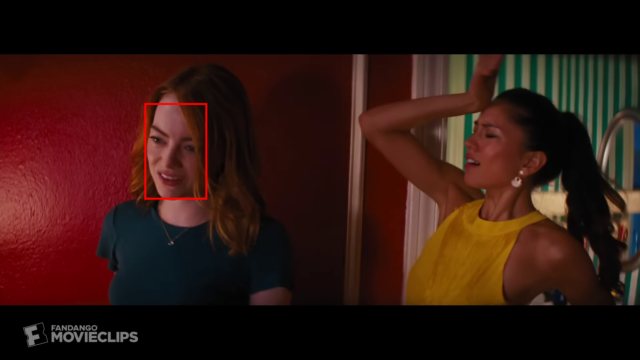

In [33]:
from IPython.display import display, clear_output
import time

try:
    for i in range(len(frames_tracked)):
        clear_output(wait=True)  # Clears the previous frame
        display(frames_tracked[i])  # Displays the new frame
        time.sleep(0.01)  # Adjust the delay as needed
except KeyboardInterrupt:
    pass

#### Save tracked video

In [30]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

In [31]:
display.Video('video_tracked.mp4', width=640)

In [ ]:
- template imge embedding
- frame-wise detect box:
    if conf:
        box - get embedding:
            if mebdding match (box, template):
                tracking added
    if box not found 
        meta timings update 
        save clip 

In [13]:
!wget https://m.media-amazon.com/images/M/MV5BMjI4NjM1NDkyN15BMl5BanBnXkFtZTgwODgyNTY1MjE@._V1_.jpg

--2025-02-07 11:23:47--  https://m.media-amazon.com/images/M/MV5BMjI4NjM1NDkyN15BMl5BanBnXkFtZTgwODgyNTY1MjE@._V1_.jpg
Resolving m.media-amazon.com (m.media-amazon.com)... 173.223.163.218, 173.223.163.202, 2600:9000:2509:ac00:1d:d7f6:39d4:e6e1, ...
Connecting to m.media-amazon.com (m.media-amazon.com)|173.223.163.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 709089 (692K) [image/jpeg]
Saving to: ‘MV5BMjI4NjM1NDkyN15BMl5BanBnXkFtZTgwODgyNTY1MjE@._V1_.jpg’

MV5BMjI4NjM1NDkyN15 100%[===================>] 692.47K  --.-KB/s    in 0.07s   

2025-02-07 11:23:47 (10.2 MB/s) - ‘MV5BMjI4NjM1NDkyN15BMl5BanBnXkFtZTgwODgyNTY1MjE@._V1_.jpg’ saved [709089/709089]

